In [1]:
import struct
from itertools import product
from pathlib import Path

import gdal
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy

gdal.AllRegister()

In [2]:
base_dir = Path.home() / "dev" / "malarial_communities"
landscan_file = base_dir / "data" / "LandScan Global 2017" / "lspop2017"

if not landscan_file.exists():
    print(f"The given file doesn't exist: {landscan_file}")
dataset = gdal.Open(str(landscan_file), gdal.GA_ReadOnly)
if not dataset:
    print(f"Could not open {landscan_file}.")
    
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
    

Driver: AIG/Arc/Info Binary Grid
Size is 43200 x 21600 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
Origin = (-180.0, 89.99999999999929)
Pixel Size = (0.0083333333333333, -0.0083333333333333)


In [3]:
band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

band_minimum = band.GetMinimum()
band_maximum = band.GetMaximum()
if not band_minimum or not band_maximum:
    (band_minimum,band_maximum) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(band_minimum,band_maximum))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))


Band Type=Int32
Min=0.000, Max=168386.000


In [4]:
scanline = band.ReadRaster(xoff=0, yoff=1000,
                        xsize=band.XSize, ysize=1,
                        buf_xsize=band.XSize, buf_ysize=1,
                        buf_type=gdal.GDT_Int32)
np_floats = np.frombuffer(scanline, dtype=np.int32)
tuple_of_floats = struct.unpack("i" * band.XSize, scanline)
for (a, b) in zip(np_floats, tuple_of_floats):
    assert a == b
print(len(tuple_of_floats))
print(type(tuple_of_floats))
print(min(np_floats))
print(max(np_floats))

43200
<class 'tuple'>
-2147483647
0


In [5]:
print(np_floats[:10])


[-2147483647 -2147483647 -2147483647 -2147483647 -2147483647 -2147483647
 -2147483647 -2147483647 -2147483647 -2147483647]


In [6]:
def make_histogram(band, bin_count=200):
    histogram_range = (band.GetMinimum(), band.GetMaximum())
    histogram = None
    edges = None
    for y_offset in range(band.YSize):
        scanline_buffer = band.ReadRaster(
            xoff=0, yoff=y_offset, xsize=band.XSize, ysize=1,
            buf_xsize=band.XSize, buf_ysize=1, buf_type=gdal.GDT_Int32,
        )
        scanline = np.frombuffer(scanline_buffer, dtype=np.int32)
        line_histogram, edges = np.histogram(scanline, bins=bin_count, range=histogram_range, density=False)
        if histogram is not None:
            histogram += line_histogram
        else:
            histogram = line_histogram

    return histogram, edges

hist, edges = make_histogram(band, bin_count=200)

In [7]:
print("Gigabytes of data")
print(hist.sum() * 4 / 1024**3)


Gigabytes of data
1.1848197393119335


(array([8., 3., 1., 2., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([   841.93,   1683.86,   2525.79,   3367.72,   4209.65,   5051.58,
          5893.51,   6735.44,   

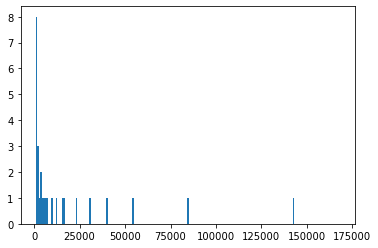

In [8]:
plt.hist(hist[1:], bins=edges[1:])


In [ ]:
def band_as_numpy(band):
    scanline_buffer = band.ReadRaster(
        xoff=0, yoff=0, xsize=band.XSize, ysize=band.YSize,
        buf_xsize=band.XSize, buf_ysize=band.YSize, buf_type=gdal.GDT_Int32,
    )
    scanline = np.frombuffer(scanline_buffer, dtype=np.int32)
    return np.reshape(scanline, (band.XSize, band.YSize))


def sub_band_as_numpy(band, y_limits):
    """Read subsets of the dataset so that we don't hold the whole thing
    in memory. It seems wasteful to reread parts, but GDAL keeps its own cache.
    """
    y_size = y_limits[1] - y_limits[0]
    scanline_buffer = band.ReadRaster(
        xoff=0,
        yoff=y_limits[0],
        xsize=band.XSize,
        ysize=y_size,
        buf_xsize=band.XSize,
        buf_ysize=y_size,
        buf_type=gdal.GDT_Int32,
    )
    scanline = np.frombuffer(scanline_buffer, dtype=np.int32)
    return np.reshape(scanline, (band.XSize, y_size))


def largest_within_distance(band, distance, limit=None):
    """
    Find the largest pixel within the given distance.
    """
    dx2 = distance**2
    value_range = (int(band.GetMinimum()), int(band.GetMaximum()))
    peaks = list()
    not_a_peak = 0
    if not limit:
        limit = (band.XSize, band.YSize)
    for j in range(limit[1]):
        y_limits = (max(0, j - distance), min(band.YSize, j + distance + 1))
        map_j = j - y_limits[0]
        map = sub_band_as_numpy(band, y_limits)
        for i in range(limit[0]):
            if map[i, map_j] < value_range[0] + 1:
                continue
            x_limits = (max(0, i - distance), min(band.XSize, i + distance + 1))
            minimum_distance = max(band.XSize, band.YSize)**2
            for (x, y) in product(range(*x_limits), range(map.shape[1])):
                if map[x, y] > map[i, map_j]:
                    minimum_distance = min(minimum_distance, (x - i)**2 + (y - map_j)**2)
            if minimum_distance > dx2:
                peaks.append((minimum_distance, i, j))
            else:
                not_a_peak += 1
    print(f"Found {len(peaks)} and discarded {not_a_peak}.")
    peaks.sort()
    return peaks

p = largest_within_distance(band, 50)

In [22]:
print(np.array(p).shape)

(24, 3)
